In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Data/

/content/drive/MyDrive/Colab Notebooks/Data


In [4]:
#!unzip intel_images.zip

In [5]:
!ls

animal10		    intel_images.zip	 raw-intel-images
archive.zip		    my_model_weights.h5  translate.py
bestanimal10predictor.hdf5  __pycache__
cats_and_dogs_filtered	    raw-img


In [ ]:
if not os.path.exists('raw-intel-images'):
  os.mkdir('raw-intel-images')

for dir in os.listdir('.'):
  if dir[0:4]=='seg_':
    shutil.move(dir,'raw-intel-images')

In [6]:
!ls

animal10		    intel_images.zip	 raw-intel-images
archive.zip		    my_model_weights.h5  translate.py
bestanimal10predictor.hdf5  __pycache__
cats_and_dogs_filtered	    raw-img


In [7]:
!ls raw-intel-images/

seg_pred  seg_test  seg_train


In [4]:
for dir in os.listdir('raw-intel-images/seg_train/seg_train'):
  print(dir)

buildings
forest
glacier
mountain
sea
street


In [5]:
for dir in os.listdir('raw-intel-images/seg_train/seg_train'):
  print(dir, len(os.listdir('raw-intel-images/seg_train/seg_train/'+dir)))

buildings 2191
forest 2271
glacier 2404
mountain 2512
sea 2274
street 2382


All of the categories have similar number of files.
So the data set is balanced(at least to an extend)

In [6]:
for dir in os.listdir("raw-intel-images/seg_test/seg_test"):
  print(dir, len(os.listdir('raw-intel-images/seg_test/seg_test/'+dir)))

buildings 437
forest 474
glacier 553
mountain 525
sea 510
street 501


Test images are also similar in number

In [ ]:
#for dir in os.listdir("raw-intel-images/seg_train/seg_train"):
#  os.listdir('raw-intel-images/seg_test/seg_test/'+dir)[0:10]

In [7]:
# data Paths

base_path = "/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images"
train_path = os.path.join(base_path,"seg_train/seg_train/")
test_path = os.path.join(base_path, "seg_test/seg_test/")

# Showing some image

In [8]:
random_image = random.sample(os.listdir(train_path+'buildings'),1)
img = mpimg.imread(train_path+'buildings/'+random_image[0])
img.shape

(150, 150, 3)

In [13]:
for dir in os.listdir(train_path):
  print(train_path+dir)

/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/buildings
/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/forest
/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/glacier
/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/mountain
/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/sea
/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_train/seg_train/street


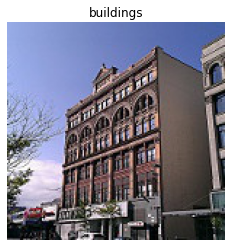

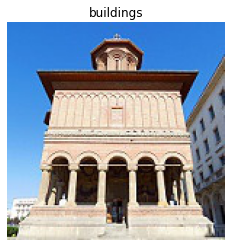

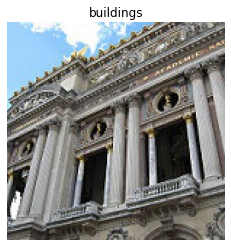

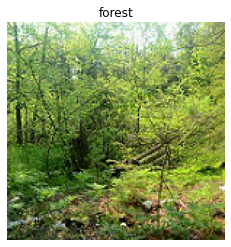

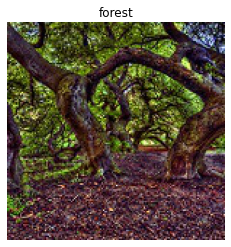

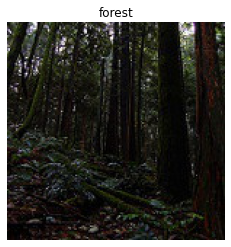

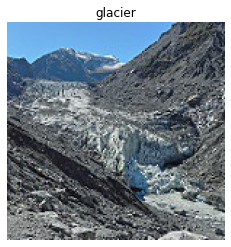

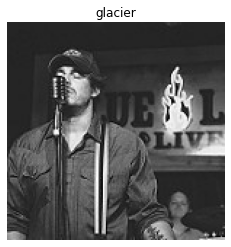

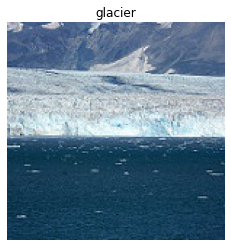

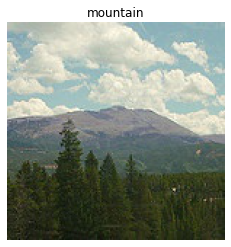

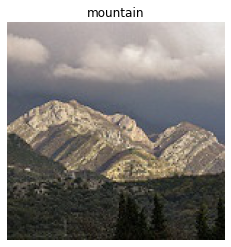

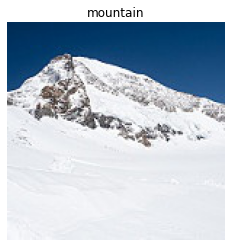

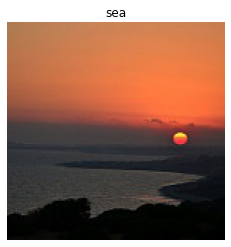

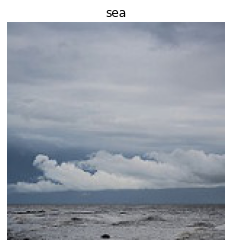

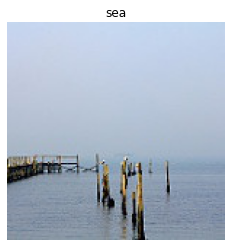

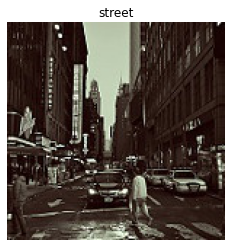

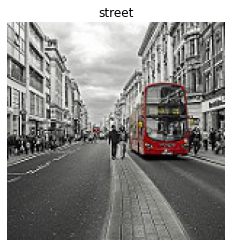

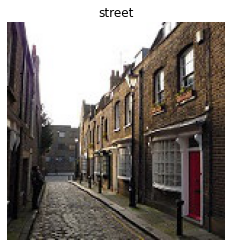

In [14]:
for dir in os.listdir(train_path):
  for i in range(3):
    random_image = random.sample(os.listdir(train_path+dir),1)
    img = mpimg.imread(train_path+dir+'/'+random_image[0])
    plt.figure()
    plt.imshow(img)
    plt.title(dir)
    plt.axis('off')

# Image Augmentation

In [9]:
datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = datagen.flow_from_directory(train_path,
                                              class_mode='categorical',
                                              target_size=(128,128),
                                              batch_size=32)

val_generator = datagen.flow_from_directory(test_path,
                                            class_mode='categorical',
                                            target_size=(128,128),
                                            batch_size=32)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

## **Creating Model**

In [11]:
from tensorflow.python.keras.layers.core import Dropout
model = Sequential([
                    Conv2D(16,(3,3), activation='relu', input_shape=(128,128,3)),
                    MaxPool2D(2,2),    #1st Layer

                    Conv2D(32,(3,3), activation='relu'),
                    MaxPool2D(2,2),    #2nd Layer

                    Conv2D(64,(3,3), activation='relu'),
                    MaxPool2D(2,2),    #3rd Layer

                    Conv2D(128,(3,3), activation='relu'),
                    MaxPool2D(2,2),    #4th Layer

                    Flatten(),

                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(6, activation='softmax')
                    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [12]:
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses.categorical_crossentropy
model.compile(optimizer='Adam',
              loss= tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=4)

mc =ModelCheckpoint('intel_model.h5',
                    monitor='val_loss',
                    mode='min',
                    save_best_only=True)

lr_rate = ReduceLROnPlateau(monitor='val_loss',patience=5, factor=0.1,mode='min')

In [15]:
hist = model.fit(train_generator,
                 epochs=20,
                 verbose=2
                 )

Epoch 1/20


KeyboardInterrupt: ignored

In [37]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Creating instance of pre-trained model
base_model = MobileNetV2(input_shape=(128,128,3),
                         include_top=False,
                         weights='imagenet'
                         )
# making layers of base model non trainable 
for layer in base_model.layers:
  layer.trainable=False

In [38]:
from tensorflow.python.keras.layers.pooling import GlobalAvgPool2D
model1 = Sequential()
model1.add(base_model)
model1.add(GlobalAvgPool2D())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(6, activation='softmax'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 module_wrapper_4 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_9 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [39]:
model1.compile(optimizer='adam',
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [40]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    class_mode='sparse',
                                                    batch_size=50,
                                                    target_size=(128,128)
                                                    )

val_generator = test_datagen.flow_from_directory(test_path,
                                                 batch_size=50,
                                                 class_mode='sparse',
                                                 target_size=(128,128)
                                                 )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [41]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [42]:
import keras

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

callback = myCallback()

In [43]:
history = model1.fit(train_generator,
                    steps_per_epoch=280,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=58,
                    verbose=2,
                    callbacks=[callback])

Epoch 1/20
280/280 - 163s - loss: 0.2988 - accuracy: 0.8928 - val_loss: 0.2523 - val_accuracy: 0.9003 - 163s/epoch - 583ms/step
Epoch 2/20
280/280 - 161s - loss: 0.1763 - accuracy: 0.9323 - val_loss: 0.2070 - val_accuracy: 0.9221 - 161s/epoch - 575ms/step
Epoch 3/20
280/280 - 163s - loss: 0.1309 - accuracy: 0.9499 - val_loss: 0.2694 - val_accuracy: 0.9076 - 163s/epoch - 581ms/step
Epoch 4/20

Reached 95% accuracy so cancelling training!
280/280 - 163s - loss: 0.1009 - accuracy: 0.9602 - val_loss: 0.2744 - val_accuracy: 0.9028 - 163s/epoch - 582ms/step


# Validation

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
class_dict = train_generator.class_indices
class_dict.items()

dict_items([('buildings', 0), ('forest', 1), ('glacier', 2), ('mountain', 3), ('sea', 4), ('street', 5)])

In [63]:
def get_key(dict1, val):
  for key,value in dict1.items():
    if val==value:
      return key
  return "key does not exist!"

get_key(class_dict, 1)

'forest'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[6.14993460e-02 1.50360465e-05 1.01499318e-05 3.09267278e-07
  1.00788759e-06 9.38474178e-01]]
This is a street


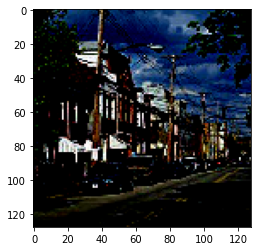

In [66]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
path= "/content/drive/MyDrive/Colab Notebooks/Data/raw-intel-images/seg_test/seg_test/street/20075.jpg"
img = load_img(path, target_size=(128,128))

i= preprocess_input(img_to_array(img))
#model1 = load_model('animal10Predictor.hdf5')
input_arr = np.array([i])
input_arr.shape 

pred = model1.predict(input_arr)

print(pred)
print("This is a "+ get_key(class_dict, np.argmax(pred)) )
plt.imshow(input_arr[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

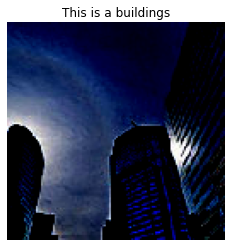

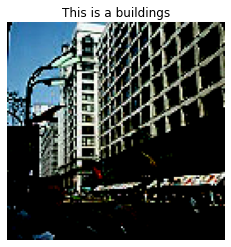

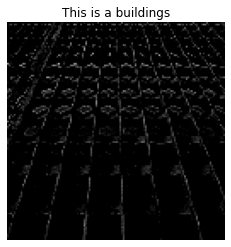

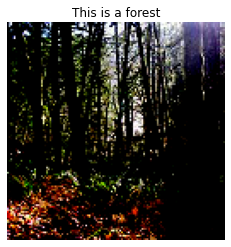

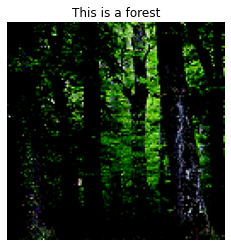

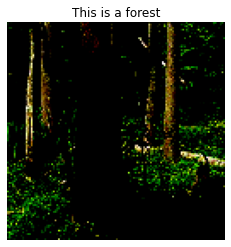

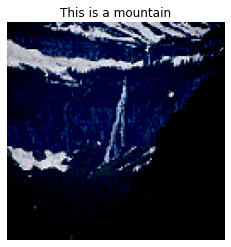

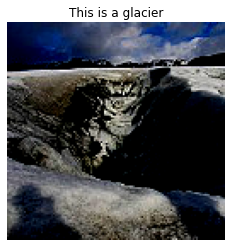

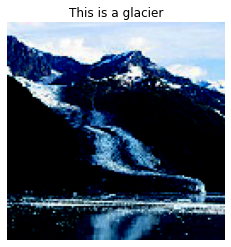

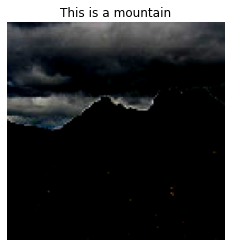

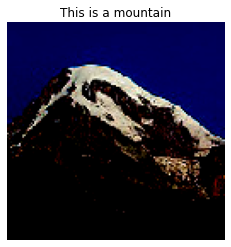

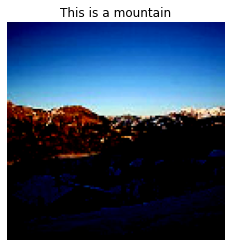

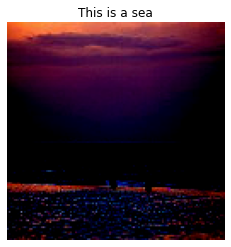

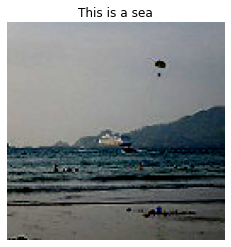

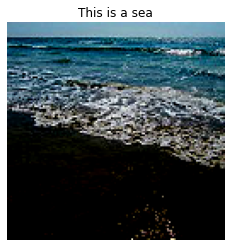

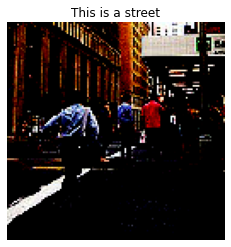

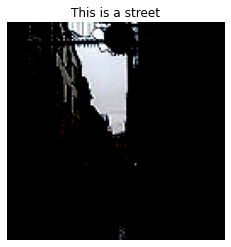

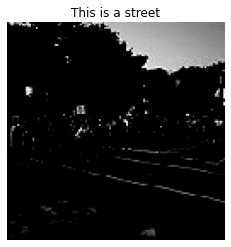

In [68]:
for dir in os.listdir(test_path):
  for i in range(3):
    random_image = random.sample(os.listdir(train_path+dir),1)
    img = load_img(train_path+dir+'/'+random_image[0], target_size=(128,128))

    i= preprocess_input(img_to_array(img))
    #model1 = load_model('animal10Predictor.hdf5')
    input_arr = np.array([i])
    input_arr.shape 
    pred = model1.predict(input_arr)

    plt.figure()
    plt.title("This is a "+ get_key(class_dict, np.argmax(pred)) )
    plt.imshow(input_arr[0])
    plt.axis('off')






# Saving model for reuse

In [54]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 module_wrapper_4 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 dense_8 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_9 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [55]:
model1.layers

In [ ]:
model1.weights

In [59]:
model1.get_layer('dense_9').get_weights()

[array([[ 3.15942280e-02,  4.48891595e-02,  1.22754835e-02,
         -1.43542156e-01,  5.65169901e-02, -7.74301216e-02],
        [-2.33535580e-02, -5.85575178e-02,  6.60668835e-02,
         -4.87241484e-02,  5.53916134e-02,  4.88250293e-02],
        [ 1.53648835e-02, -7.48329759e-02, -1.68062877e-02,
          1.05747133e-02, -7.07645342e-02, -2.33191159e-02],
        ...,
        [ 5.19406423e-02,  6.08565658e-02, -7.99476281e-02,
          4.75640334e-02,  6.50741011e-02, -1.94369677e-05],
        [-5.11507764e-02,  1.61978807e-02,  5.51520288e-02,
         -8.28626193e-03, -4.12709489e-02, -6.15427457e-02],
        [-8.15431103e-02,  4.46757860e-03, -3.78613994e-02,
         -5.40282018e-02,  2.34453361e-02, -6.83467230e-03]], dtype=float32),
 array([ 0.00073332, -0.00854013, -0.00752025,  0.00828741,  0.00650319,
        -0.00219259], dtype=float32)]

In [60]:
model1.save_weights('./intelimage_mobilenet_weights.h5')

In [71]:
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAvgPool2D())
model2.add(Dense(1024, activation='relu'))
model2.add(Dense(6, activation='softmax'))

In [72]:
model2.load_weights('./intelimage_mobilenet_weights.h5')

In [74]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 module_wrapper_6 (ModuleWra  (None, 1280)             0         
 pper)                                                           
                                                                 
 dense_12 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_13 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 3,575,878
Trainable params: 1,317,894
Non-trainable params: 2,257,984
_________________________________________________________________


In [75]:
model2.get_layer('dense_13').get_weights()

[array([[ 3.15942280e-02,  4.48891595e-02,  1.22754835e-02,
         -1.43542156e-01,  5.65169901e-02, -7.74301216e-02],
        [-2.33535580e-02, -5.85575178e-02,  6.60668835e-02,
         -4.87241484e-02,  5.53916134e-02,  4.88250293e-02],
        [ 1.53648835e-02, -7.48329759e-02, -1.68062877e-02,
          1.05747133e-02, -7.07645342e-02, -2.33191159e-02],
        ...,
        [ 5.19406423e-02,  6.08565658e-02, -7.99476281e-02,
          4.75640334e-02,  6.50741011e-02, -1.94369677e-05],
        [-5.11507764e-02,  1.61978807e-02,  5.51520288e-02,
         -8.28626193e-03, -4.12709489e-02, -6.15427457e-02],
        [-8.15431103e-02,  4.46757860e-03, -3.78613994e-02,
         -5.40282018e-02,  2.34453361e-02, -6.83467230e-03]], dtype=float32),
 array([ 0.00073332, -0.00854013, -0.00752025,  0.00828741,  0.00650319,
        -0.00219259], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

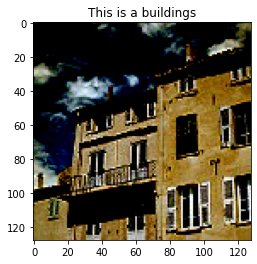

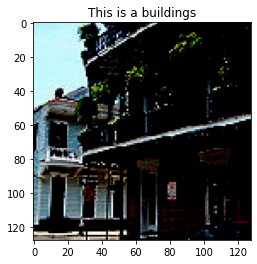

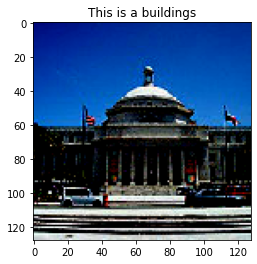

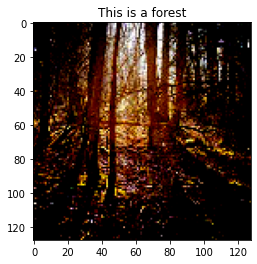

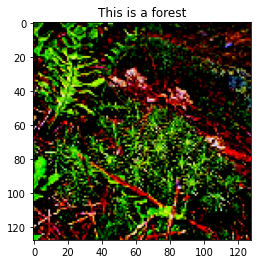

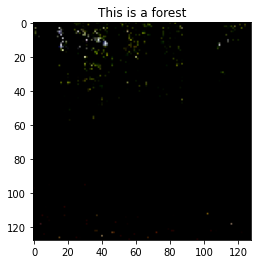

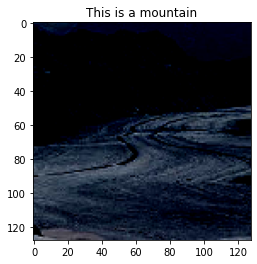

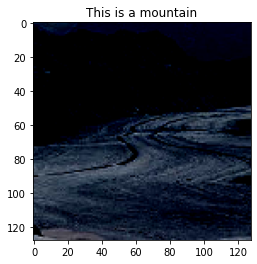

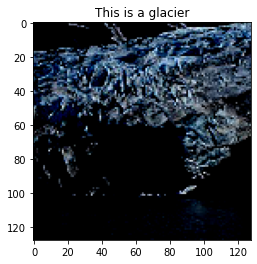

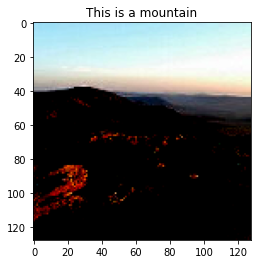

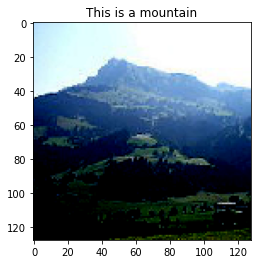

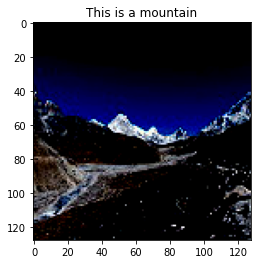

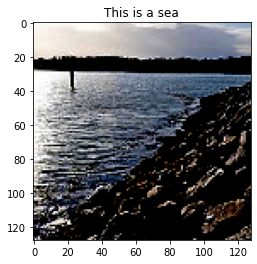

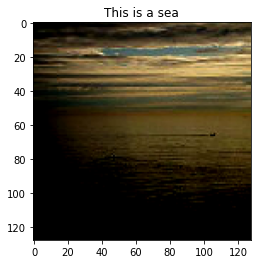

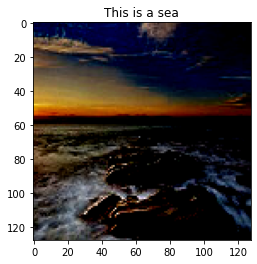

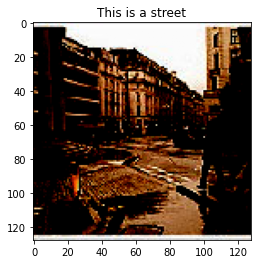

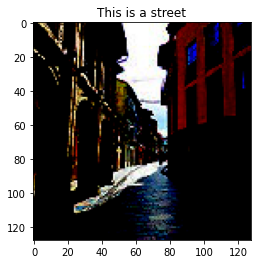

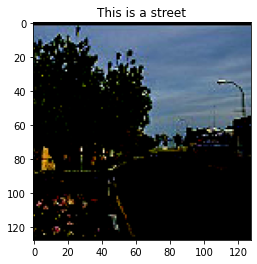

In [84]:
for dir in os.listdir(test_path):
  for i in range(3):
    random_image = random.sample(os.listdir(test_path+dir),1)
    img = load_img(test_path+dir+'/'+random_image[0], target_size=(128,128))
    i = preprocess_input(img_to_array(img))
    img_array = np.array([i])

    pred2 = model2.predict(img_array)
    plt.figure()
    plt.imshow(img_array[0])
    plt.title("This is a "+ get_key(class_dict, np.argmax(pred2)))
    plt.axis=False